# Vector Quantization using k-Means

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Vector quantization of images using the k-means algorithm by grouping neighboring pixels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans

Function to transform a color image to grayscale. Here, we use the method employed in PAL and NTSC and described in ITU-R Rec.601. According to this standard the luma is obtained as
\begin{equation*}
Y^\prime = 0.2989\cdot R + 0.587\cdot G + 0.114\cdot B 
\end{equation*}

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Load an image, needs to be an RGB image (24 bit color information), transform it to gray scale and display

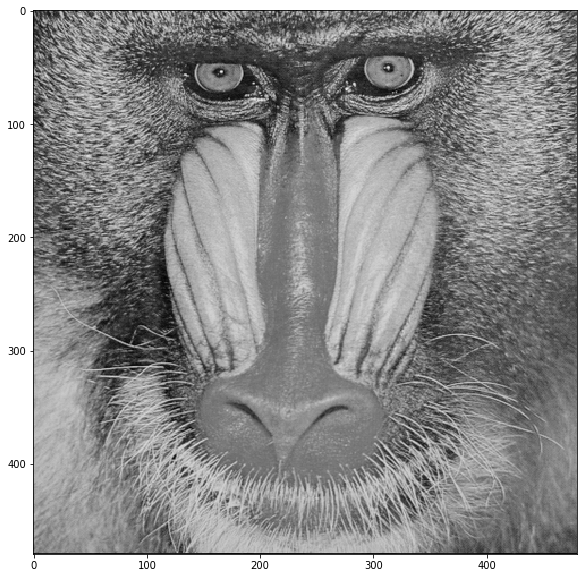

In [3]:
image = rgb2gray(mpimg.imread('Mandrill.png'))
plt.figure(1,figsize=(10,10))
plt.imshow(image,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

*** 
This function performs simple scalar quantization without any optimization of the quantization levels

In [5]:
def quantize_scalar(data,bits):
    levels = np.power(2.0,bits)
    pdata = np.minimum(np.floor(data*levels), (levels-1)*np.ones(data.shape))/(levels-1)
    return pdata

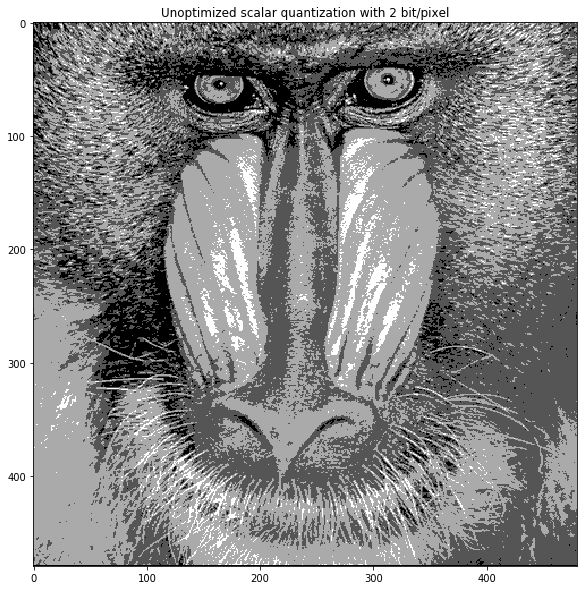

In [6]:
image_3 = quantize_scalar(image,2)
plt.figure(1,figsize=(10,10))
plt.imshow(image_3,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.title('Unoptimized scalar quantization with 2 bit/pixel')
plt.show()


*** 
Construct a more general scalar/vector quantizer based on the k-means algorithm.
We start by grouping neighboring pixels of size blocksize x blocksize and assigning to each bit an equivalent of bits pixel
This means that the codebook contains $2^{\texttt{bits}\times \texttt{blocksize}\times \texttt{blocksize}}$ entries. After rearranging the picture, we apply k-means  to find the clusters which represent to the codebook entries
Based on the clusters, the image is put together. We use the k-means implementation from the scikit-learn library

In [6]:
def vector_quantize_by_kmeans(data, blocksize, bits):
    codebook_size = np.int(pow(2,blocksize*blocksize*bits))

    i_range = np.arange(0,data.shape[0],blocksize)
    j_range = np.arange(0,data.shape[1],blocksize)                  
    points = np.zeros((len(i_range)*len(j_range), blocksize*blocksize))
    ii=0
    for i in i_range:
        for j in j_range:
            idx = np.ix_(np.arange(0,blocksize)+i,np.arange(0,blocksize)+j)
            pixelgroup = np.reshape(data[idx],(1,blocksize*blocksize))
            points[ii,:] = pixelgroup
            ii += 1

    kmeans = KMeans(n_clusters=codebook_size, random_state=0, n_jobs=8, n_init=8, precompute_distances=True).fit(points)
    
    reconstruct = np.zeros_like(data)
    ii = 0
    for i in np.arange(0,data.shape[0],blocksize):
        for j in np.arange(0,data.shape[1],blocksize):
            idx = np.ix_(np.arange(0,blocksize)+i,np.arange(0,blocksize)+j)
            reconstruct[idx] = np.reshape(kmeans.cluster_centers_[kmeans.labels_[ii]], (blocksize, blocksize))
            ii += 1

    return reconstruct

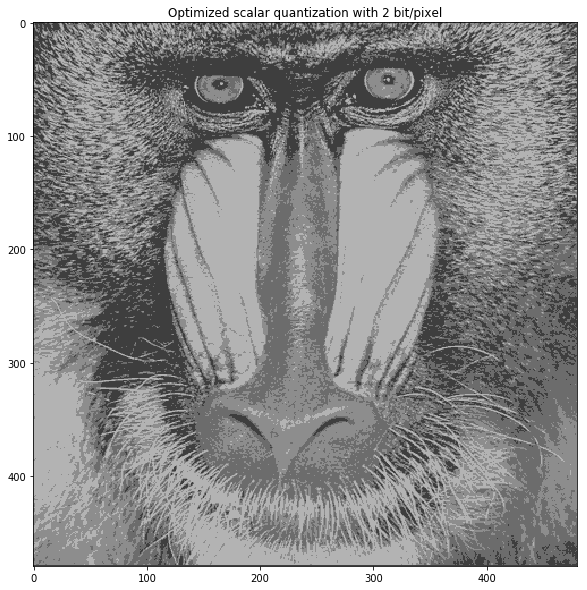

In [7]:
reconstruct = vector_quantize_by_kmeans(image, 1, 2)
plt.figure(1,figsize=(10,10))
plt.title('Optimized scalar quantization with 2 bit/pixel')
plt.imshow(reconstruct,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

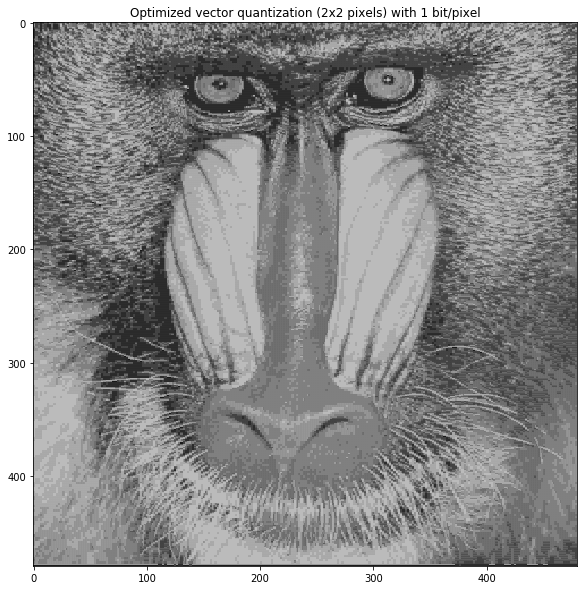

In [8]:
reconstruct = vector_quantize_by_kmeans(image, 2, 1)

plt.figure(1,figsize=(10,10))
plt.title('Optimized vector quantization (2x2 pixels) with 1 bit/pixel')
plt.imshow(reconstruct,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

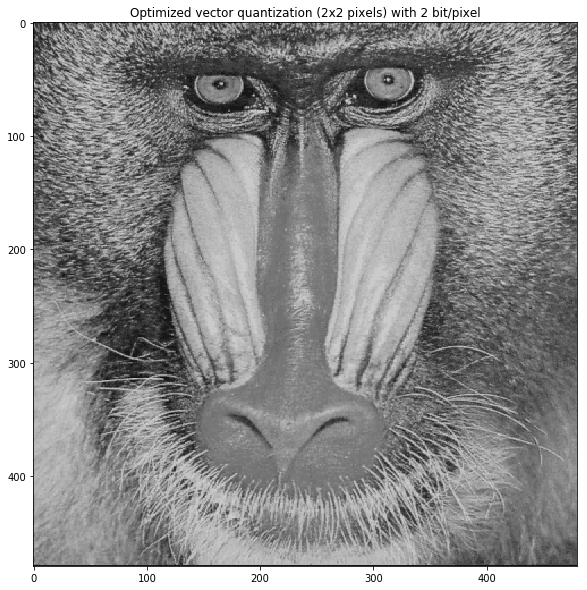

In [9]:
reconstruct = vector_quantize_by_kmeans(image, 2, 2)

plt.figure(1,figsize=(10,10))
plt.title('Optimized vector quantization (2x2 pixels) with 2 bit/pixel')
plt.imshow(reconstruct,cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()
